<a href="https://colab.research.google.com/github/laolucharles1/Data-Analytics-Machine-Learning-Projects/blob/main/Visualizing_heatmaps_of_class_activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the VGG16 network with pretrained weights

In [15]:
from keras.applications.vgg16 import VGG16

model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 0s 0us/step


Preprocessing an input image for VGG16

In [20]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/content/African elephants.jpeg' #local path to the target image



def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [24]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])
print(np.argmax(preds[0])) # represents the African elephant class

1/1 [==============================] - 0s 388ms/step
[('n02504458', 'African_elephant', 0.639169), ('n01871265', 'tusker', 0.2481159), ('n02504013', 'Indian_elephant', 0.053186774)]
386


Setting up the GRAD-CAM algorithm

Setting up a model that returns the last convolutional output

In [25]:
from tensorflow import keras

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

Reapplying the classifier on top of the last convolutional output

In [26]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

Retrieving the gradients of the top predicted class

In [27]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

Gradient pooling and channel-importance weighting

In [28]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

Heatmap post-processing



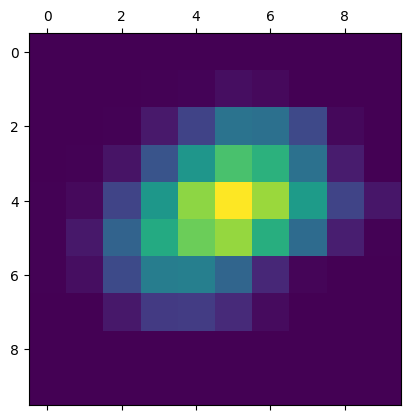

In [30]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Superimposing the heatmap on the original picture

In [34]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('/content/elephant_cam.jpg', superimposed_img)

True

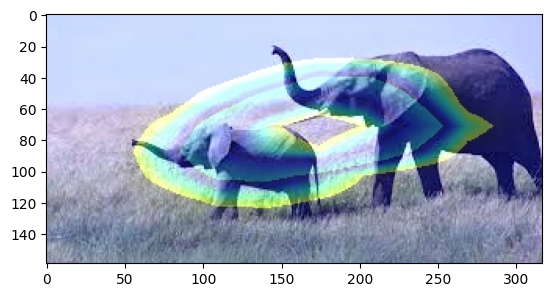

In [35]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg


image = mpimg.imread("/content/elephant_cam.jpg")
plt.imshow(image)
plt.show()